In [ ]:
pip install mord

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
from sklearn.datasets import load_iris


%matplotlib inline

In [ ]:
crash_df = pd.read_csv("Crash_Excel.csv")

In [ ]:
crash_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195092 entries, 0 to 195091
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Agency Name                    195092 non-null  object
 1   ACRS Report Type               195092 non-null  object
 2   Crash Day                      195092 non-null  object
 3   Crash Time                     195092 non-null  object
 4   Route Type                     176046 non-null  object
 5   Non-Motor Related              195092 non-null  int64 
 6   Collision Type                 194507 non-null  object
 7   Weather                        181736 non-null  object
 8   Surface Condition              172806 non-null  object
 9   Light                          193647 non-null  object
 10  Traffic Control                167593 non-null  object
 11  Driver Substance Abuse         163772 non-null  object
 12  Driver At Fault                195092 non-nu

In [ ]:
new_df = crash_df.dropna(subset=['Injury Severity']).copy()

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 193641 entries, 0 to 195091
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Agency Name                    193641 non-null  object
 1   ACRS Report Type               193641 non-null  object
 2   Crash Day                      193641 non-null  object
 3   Crash Time                     193641 non-null  object
 4   Route Type                     174961 non-null  object
 5   Non-Motor Related              193641 non-null  int64 
 6   Collision Type                 193056 non-null  object
 7   Weather                        180285 non-null  object
 8   Surface Condition              171749 non-null  object
 9   Light                          192196 non-null  object
 10  Traffic Control                166501 non-null  object
 11  Driver Substance Abuse         162321 non-null  object
 12  Driver At Fault                193641 non-null  o

In [ ]:
# Clean up the Injury Severity column by removing extra spaces and standardizing to title case
new_df.loc[:, 'Injury Severity'] = new_df['Injury Severity'].str.strip().str.title()
# Create a new binary target column which is 1 if Fatal Injury, and 0 otherwise
new_df.loc[:, 'Fatal Crash'] = (new_df['Injury Severity'] == 'Fatal Injury').astype(int)

In [ ]:
# This is the frequency of each injury severity type after previous cleaning
print(new_df['Injury Severity'].value_counts())

Injury Severity
No Apparent Injury          159044
Possible Injury              18999
Suspected Minor Injury       13822
Suspected Serious Injury      1598
Fatal Injury                   178
Name: count, dtype: int64


In [ ]:
df_encoded = pd.get_dummies(new_df, drop_first=True)

In [ ]:
# The dummy-encoded columns that were created from 'Injury Severity'
print(df_encoded.columns[df_encoded.columns.str.contains("Injury Severity")])

Index(['Injury Severity_No Apparent Injury', 'Injury Severity_Possible Injury',
       'Injury Severity_Suspected Minor Injury',
       'Injury Severity_Suspected Serious Injury'],
      dtype='object')


In [ ]:
# Defined the target variable for classification: 1 = Fatal Injury, 0 = All Others
y = df_encoded['Fatal Crash']

# I would now start with all the features and then drop the target
X = df_encoded.drop(columns=['Fatal Crash'])

# after I would now further remove all dummy-encoded 'Injury Severity_' columns
X = X.drop(columns=X.columns[X.columns.str.contains("Injury Severity_")])

In [ ]:
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [ ]:
classTree = tree.DecisionTreeClassifier(random_state=0, max_depth=17, class_weight='balanced')
classTree.fit(train_X, train_y)

DecisionTreeClassifier(class_weight='balanced', max_depth=17, random_state=0)

In [ ]:
train_pred = classTree.predict(train_X)
valid_pred = classTree.predict(valid_X)

print("Training Performance:")
classificationSummary(train_y, train_pred, class_names=['Non-Fatal', 'Fatal'])

print("\nValidation Performance:")
classificationSummary(valid_y, valid_pred, class_names=['Non-Fatal', 'Fatal'])

Training Performance:
Confusion Matrix (Accuracy 0.9995)

          Prediction
   Actual Non-Fatal     Fatal
Non-Fatal    116016        63
    Fatal         0       105

Validation Performance:
Confusion Matrix (Accuracy 0.9992)

          Prediction
   Actual Non-Fatal     Fatal
Non-Fatal     77332        52
    Fatal         7        66


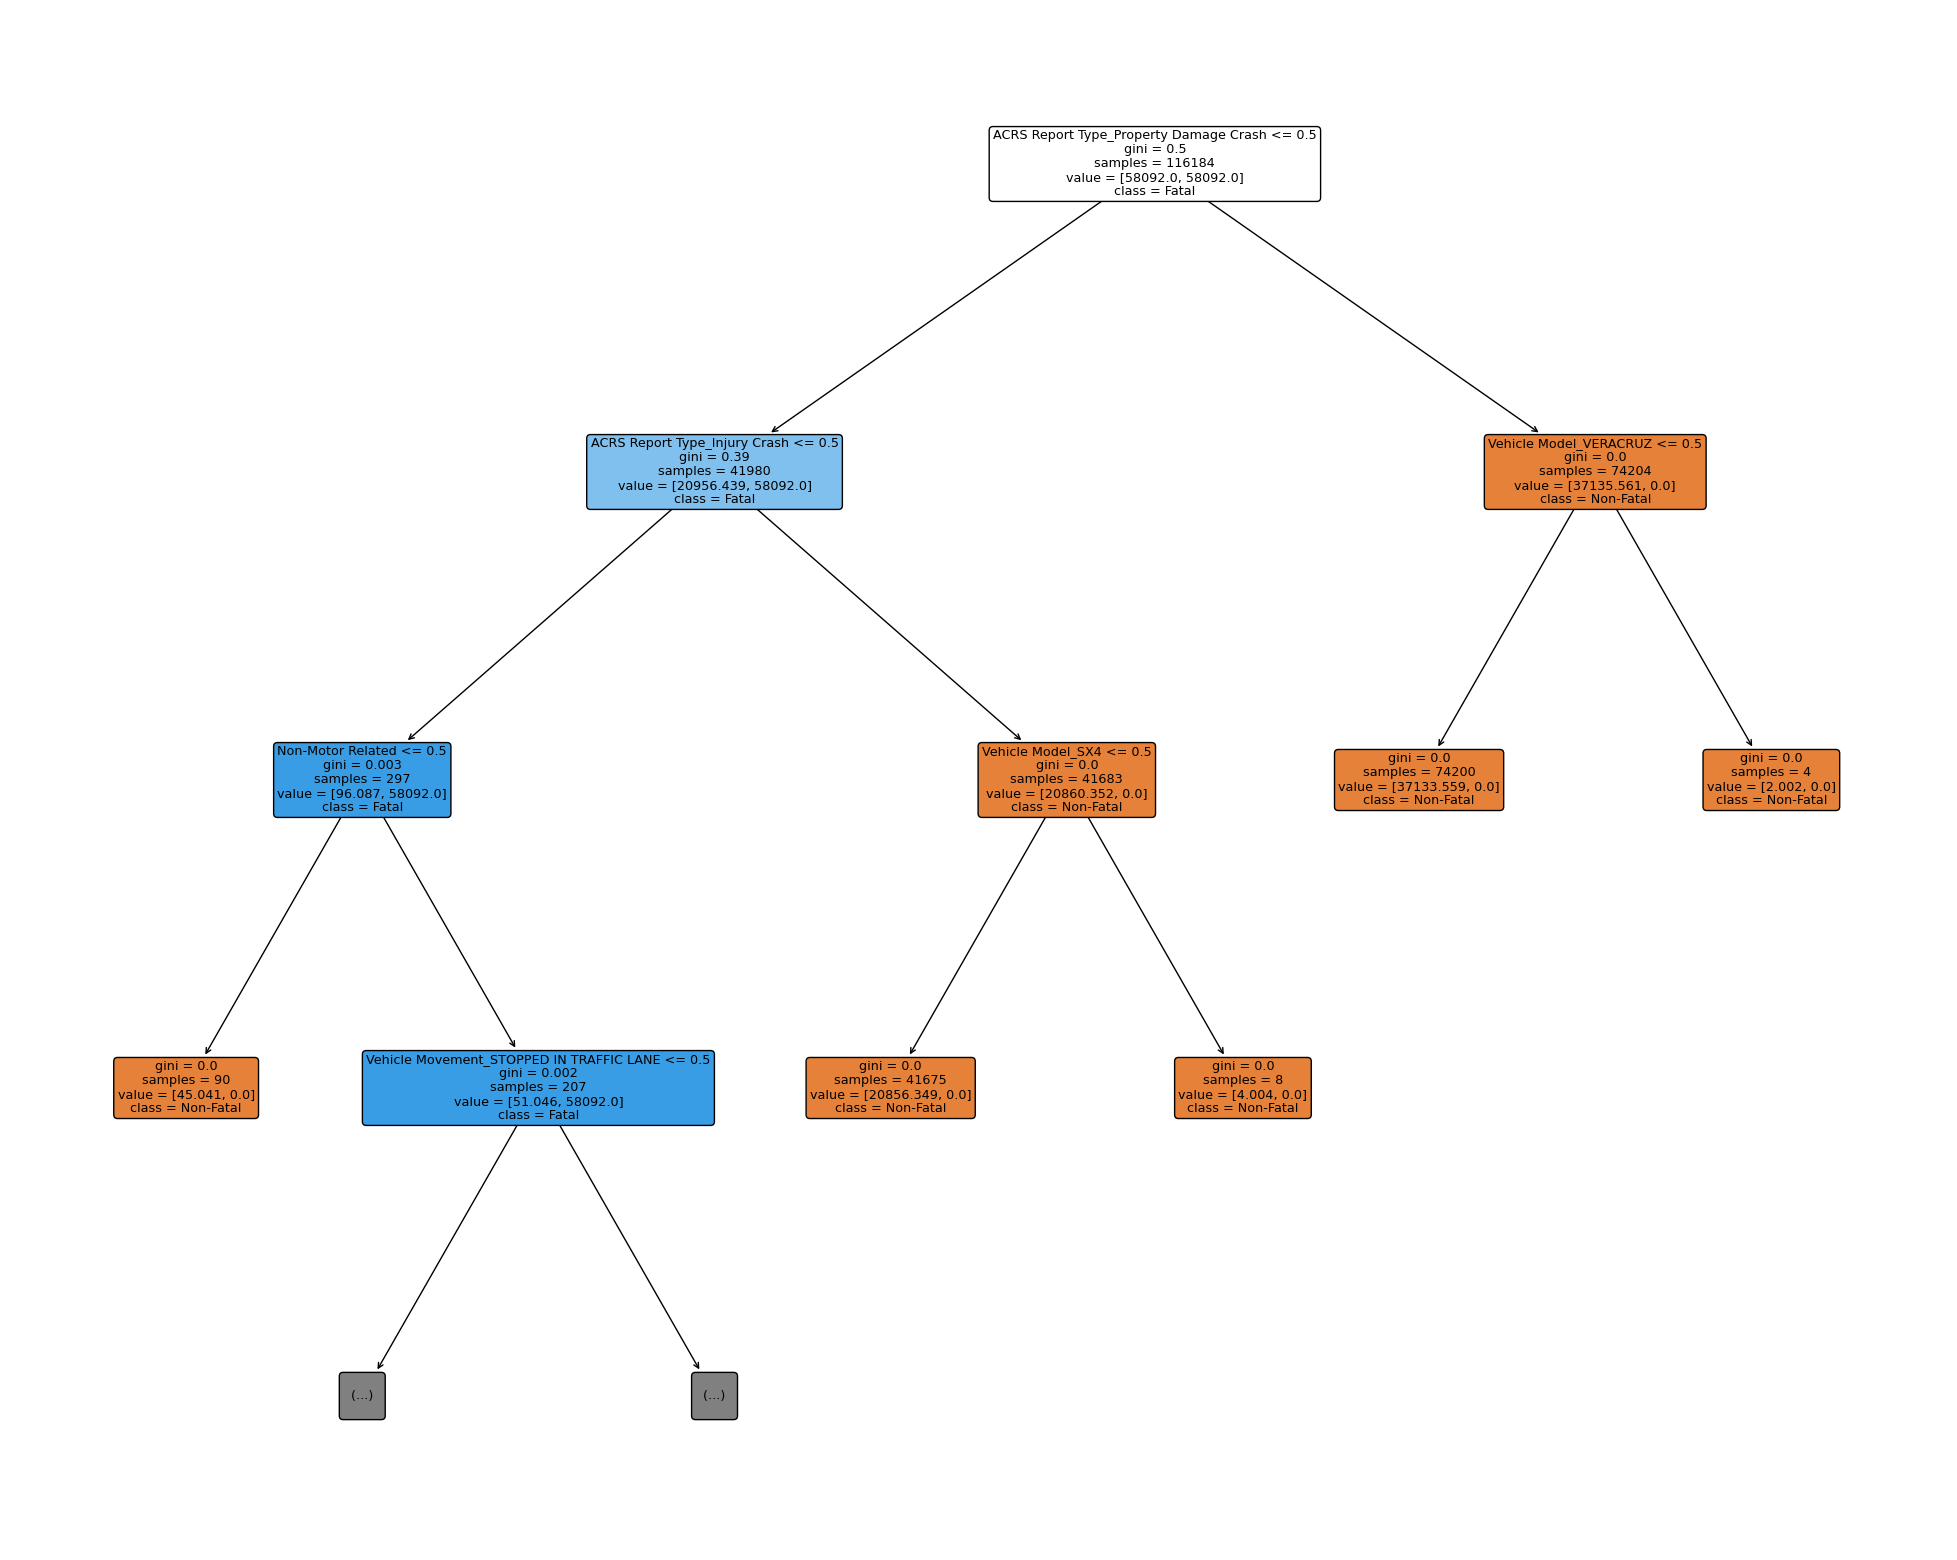

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(classTree,
                   feature_names=X.columns,
                   class_names=['Non-Fatal', 'Fatal'],  # class labels
                   filled=True,                         # color nodes by class
                   max_depth=3,                         # to better view the tree
                   rounded=True,
)

fig.savefig("decision_tree_FatalCrash.png")

If it isn't a property damage crash and instead an injury crash, the model considers fatality a real possibility.
If it is property damage only, the model assumes Non-Fatal which makes sense, which makes sense as it would of otherwise been stated as an huamn injury on the decision tree. In this tree the fatality is highlighted in the blue with the property damage are issued in orange (non fatal)

# Naive Bayes Classifier

### Import required packages

In [ ]:
from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pylab as plt

import dmba
from dmba import classificationSummary, gainsChart

%matplotlib inline

no display found. Using non-interactive Agg backend


In [ ]:
crash_df = pd.read_csv("Crash_Excel.csv")
crash_df.columns = [col.strip().replace(' ', '_') for col in crash_df.columns]
print(crash_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195092 entries, 0 to 195091
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   Agency_Name                    195092 non-null  object
 1   ACRS_Report_Type               195092 non-null  object
 2   Crash_Day                      195092 non-null  object
 3   Crash_Time                     195092 non-null  object
 4   Route_Type                     176046 non-null  object
 5   Non-Motor_Related              195092 non-null  int64 
 6   Collision_Type                 194507 non-null  object
 7   Weather                        181736 non-null  object
 8   Surface_Condition              172806 non-null  object
 9   Light                          193647 non-null  object
 10  Traffic_Control                167593 non-null  object
 11  Driver_Substance_Abuse         163772 non-null  object
 12  Driver_At_Fault                195092 non-nu

In [ ]:
new_df = crash_df.dropna(subset=['Injury_Severity']).copy()

# Cleaning Injury_Severity
new_df['Injury_Severity'] = new_df['Injury_Severity'].str.strip().str.title()

# Creating binary target: 1= injury, 0= no injury
new_df['Injury_Occurred'] = (new_df['Injury_Severity'] != 'No Apparent Injury').astype(int)

# Extracting hour from time strong
new_df['Crash_Hour'] = new_df['Crash_Time'].astype(str).str.extract(r'(\d{1,2})')[0]
new_df = new_df[new_df['Crash_Hour'].notnull()]
new_df['Crash_Hour'] = new_df['Crash_Hour'].astype(int)

# Create time of day bins
new_df['Time_Of_Day'] = pd.cut(new_df['Crash_Hour'], bins=[-1, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

In [ ]:
# converting vehicle year and splitting into age groups for simplicity
new_df['Vehicle_Year'] = new_df['Vehicle_Year'].astype(int)
new_df['Vehicle_Age_Group'] = pd.cut(
    2025 - new_df['Vehicle_Year'],
    bins=[-1, 5, 10, 20, 100],
    labels=['0-5 yrs', '6-10 yrs', '11-20 yrs', '20+ yrs']
)

In [ ]:
selected_features = [
    'Weather', 'Surface_Condition', 'Time_Of_Day', 'Speed_Limit',
    'Collision_Type', 'Crash_Day', 'Vehicle_Body_Type',
    'Vehicle_Age_Group', 'Vehicle_Make'
]

model_df = new_df[selected_features + ['Injury_Occurred']].dropna()

In [ ]:
# converting to categorical variables
for col in selected_features:
    model_df[col] = model_df[col].astype('category')

In [ ]:
# splitting the data into training and validation
X = pd.get_dummies(model_df[selected_features], drop_first=True)
y = model_df['Injury_Occurred'].astype('category')
classes = list(y.cat.categories)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=1)

In [ ]:
# training naive bayes model
nb_model = MultinomialNB(alpha=0.01)
nb_model.fit(X_train, y_train)

# Predict class probabilities and outcomes
predProb_train = nb_model.predict_proba(X_train)
predProb_valid = nb_model.predict_proba(X_valid)

y_train_pred = nb_model.predict(X_train)
y_valid_pred = nb_model.predict(X_valid)

In [ ]:
# evaluting performance
print("Training Performance:")
classificationSummary(y_train, y_train_pred, class_names=['No Injury', 'Injury'])

Training Performance:
Confusion Matrix (Accuracy 0.8110)

          Prediction
   Actual No Injury    Injury
No Injury     76065       252
   Injury     17642       734


In [ ]:
# evaluating performance
print("\nValidation Performance:")
classificationSummary(y_valid, y_valid_pred, class_names=['No Injury', 'Injury'])


Validation Performance:
Confusion Matrix (Accuracy 0.8059)

          Prediction
   Actual No Injury    Injury
No Injury     50441       354
   Injury     11900       434


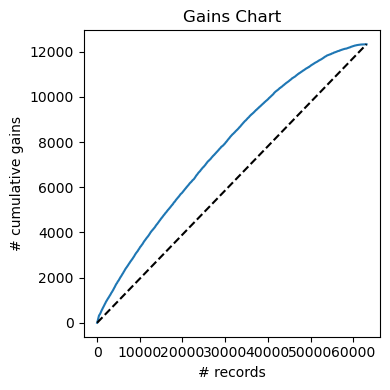

In [ ]:
# plotting gains chart
df = pd.DataFrame({'actual': y_valid.cat.codes, 'prob': predProb_valid[:, 1]})
df = df.sort_values(by='prob', ascending=False).reset_index(drop=True)

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)
gainsChart(df.actual, ax=ax)
plt.title('Gains Chart')
plt.tight_layout()
plt.show()